In [1]:
import csv
import gzip
import os
import matplotlib as mpl
import scipy.io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/dataset4.csv")
mat = np.array(mat)
datafile = 'dataset4.tpm.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('gene_name')
cells = list(df.columns.values)
features_path = os.path.join(matrix_dir, "features4.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes4.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
print(mat.shape)

compiled!
(518, 57822)


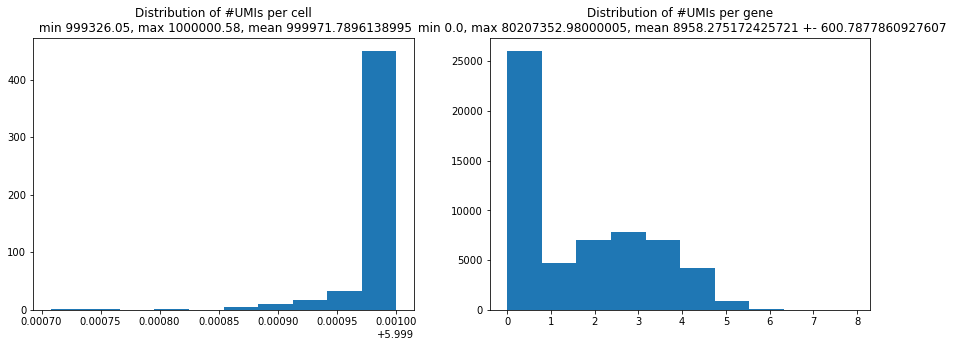

In [3]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));

(518, 13720)


Text(0.5, 1.0, 'Distribution of CV, mean 0.7336748386076576 sd 0.7539717748791853')

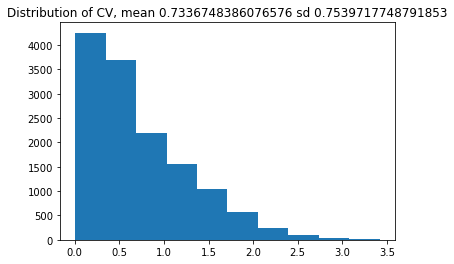

In [4]:
low_expr_thr = 1000
high_expr_thr = 80000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
print(mat.shape)
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 1000.31, max 26509.84, mean 2741.465768703337 +1 40.688649641238904')

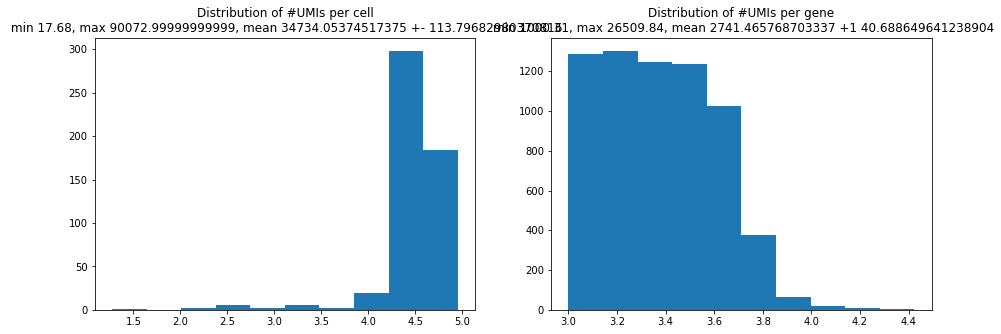

In [5]:
mat = mat[:, CV >= 0.6]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

(517, 6563)
done


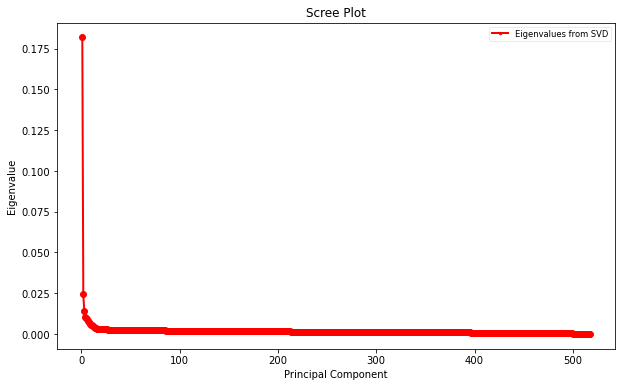

In [6]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
U, S, V = np.linalg.svd(mat) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(mat)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
print(mat.shape)
print('done')

(517, 6563)
517


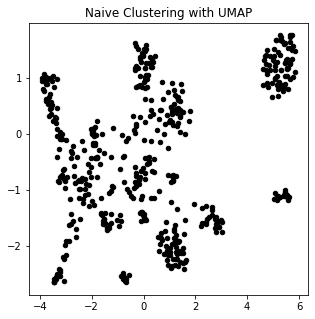

In [7]:
print(mat.shape)
pca = PCA(n_components=90)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
true_coords = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(mat_reduce)
print(len(embedding))
for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
    true_coords.update({cells[i]:str(embedding[i]).strip()})
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:,0],embedding[:,1], s=20, c='black')
plt.title('Naive Clustering with UMAP')
plt.savefig('Naive Clustering.png')

AffinityPropagation
[168 127 126  96]
MeanShift
[419  98]
SpectralClustering
[410  20  76  11]
Ward
[195  96 147  79]
AgglomerativeClustering
[406  76  20  15]
DBSCAN
[ 20  91  11 118   9  24  21  28  42  53  76   8]
Birch
[238  96 137  46]
GaussianMixture
[ 96 161 173  87]


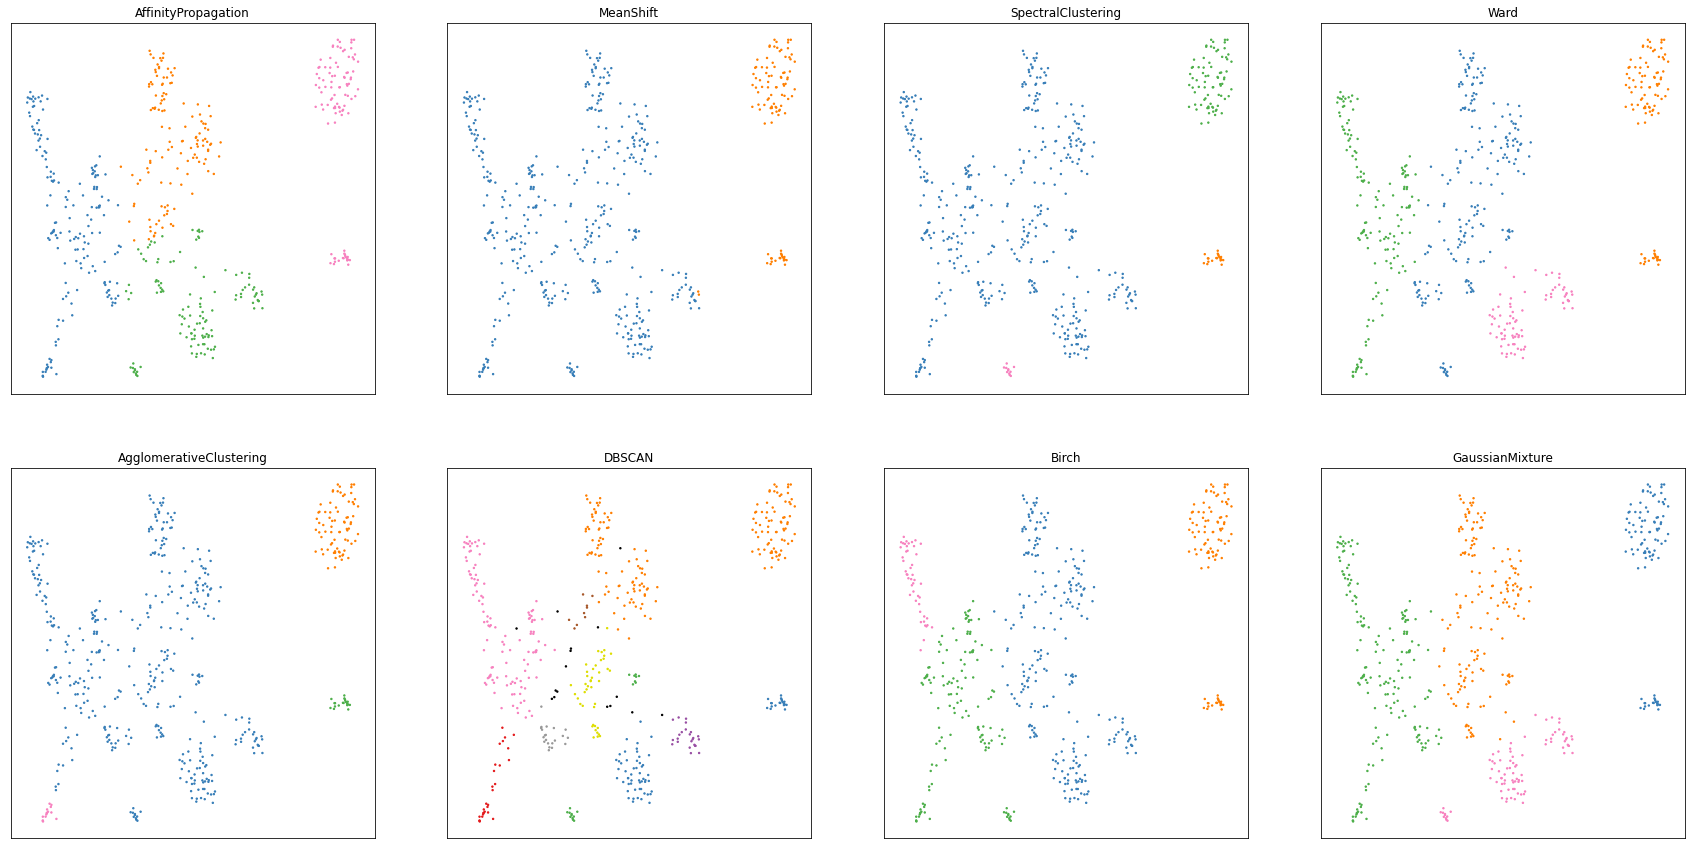

In [8]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':4}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(30,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('All Clusters.png')


In [47]:
def FindTrueLabels(algorithm):
    algorithm_coords = {}
    y_pred = algorithm.labels_.astype(np.int)
    for i in range(len(embedding)):
        if y_pred[i] == 0:
            color = 'red'
        elif y_pred[i] == 1:
            color = 'green'
        elif y_pred[i] == 2: 
            color = 'blue'
        else:
            color = 'purple'
        #plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

In [13]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

def DataCollectionMolecularSubtypeTvP(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
        
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0

    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    
    correctCount = 0
    for i in truthnum1:
        if(truthnum1[i] == 'black'):
            correctCount += 1
    return truthnum1, correctCount

In [11]:
def DataCollectionMolecularSubtype(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorous = {}
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    tumor = []
    tc = open('tumorous.txt').readlines()
    for lines in tc:
        if(lines == 'Tumor\n'):
            tumor.append("red")
        elif(lines == 'nonTumor\n'):
            tumor.append("black")
        else:
            tumor.append("white")
    for i in range (0, len(embedding)):
        tumorous.update({cells[i]:tumor[i]})
        
        
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
    print(len(dp_line) + len(erp_line) + len(her2p_line) + len(tnbc_line))  
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0

    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0087FF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#AED9FF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#49657D'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#103757'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FF3B00'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#F9D2C7'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#866961'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#5A1806'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FFA200'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FFEED1'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#696051'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#5D3B02'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    
    print(len(embedding))
    print(len(truthnum1))
    return truthnum1, truthnum2

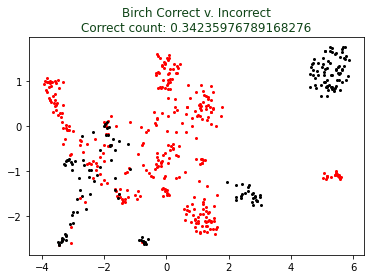

In [16]:
def DataViz(figname, algorithm, cluster1, cluster2, cluster3, cluster4, results):
    coloring = []
    truthnum1, correctCount = DataCollectionMolecularSubtypeTvP(algorithm, cluster1, cluster2, cluster3, cluster4, results)
    for i in truthnum1:
        coloring.append(truthnum1[i])
    for i in range(len(truthnum1)):
        plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
    labels = algorithm.labels_
    plt.savefig(figname)
    plt.title("Birch Correct v. Incorrect" + "\n" + "Correct count: " + str(correctCount/len(truthnum1)))

# truthnum1, truthnum2 = DataCollectionMolecularSubtype(birch, "birch_subtype1.txt", "birch_subtype2.txt", "birch_subtype3.txt", "birch_subtype4.txt", "birch_subtype_results.txt")
# plt.figure(figsize=(50, 50))
# plt.xticks(())
# plt.yticks(())
# for g in range(len(truthnum1)):
#     plt.scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=4, color="white")
#     mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
#     plt.annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=35) 
# plt.savefig("Birch Molecular Subtype Type.png")   
# plt.show()

DataViz("Birch MS Predicted v. Truth.png", birch, "birch_subtype1.txt", "birch_subtype2.txt", "birch_subtype3.txt", "birch_subtype4.txt", "birch_subtype_results.txt")
#DataViz("Spectral Truth Plot.png", spectral, "spectral_cluster1.txt", "spectral_cluster2.txt", "spectral_cluster3.txt", "spectral_results.txt")
#DataViz("Birch Truth Plot.png", birch, "birch_cluster1.txt", "birch_cluster2.txt", "birch_cluster3.txt", "birch_results.txt")

#DataViz("Ward Truth Plot.png", ward, "ward_cluster1.txt", "ward_cluster2.txt", "ward_cluster3.txt", "ward_cluster4.txt", "ward_results.txt")

AffinityPropagation
[168 127 126  96]
MeanShift
[419  98]
SpectralClustering
[506  11]
Ward
[421  96]
AgglomerativeClustering
[ 96 421]
DBSCAN
[ 20  91  11 118   9  24  21  28  42  53  76   8]
Birch
[421  96]
GaussianMixture
[ 96 421]


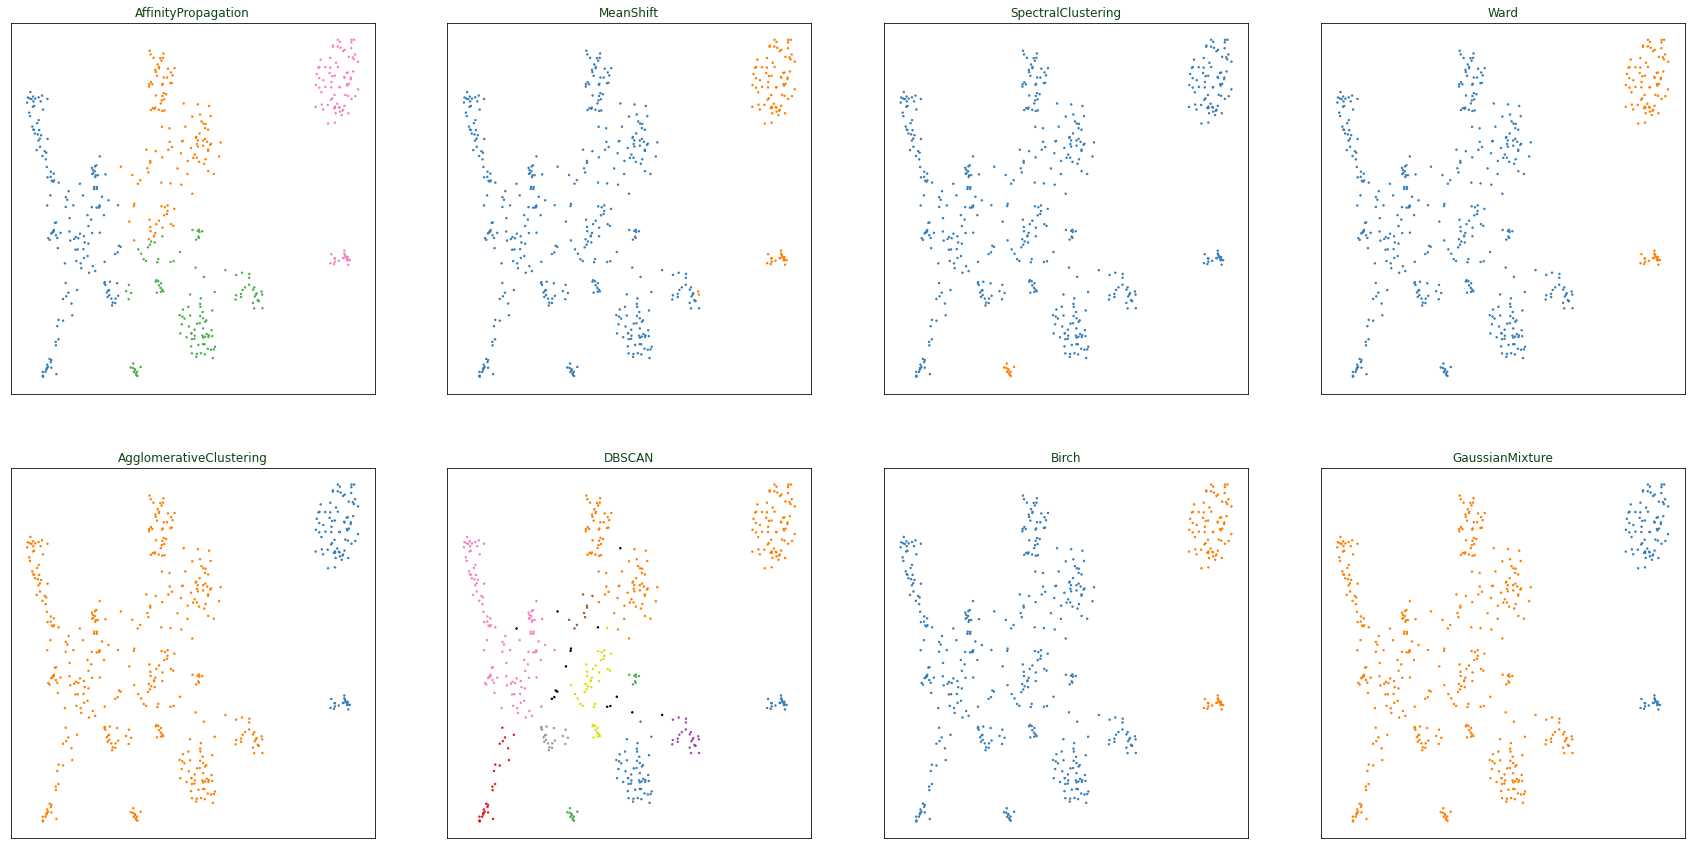

In [44]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':2}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(30,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('All Clusters.png')


In [48]:
def FindTrueLabelsTumor(algorithm):
    algorithm_coords = {}
    y_pred = algorithm.labels_.astype(np.int)
    for i in range(len(embedding)):
        #plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

In [70]:
def DataCollectionTumor(algorithm, cluster_1, cluster_2, cluster_3, results):
    labels = FindTrueLabelsTumor(algorithm)
    res = open(results, "w")
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorousCells = []
    nonTumorousCells = []
    NACells = []
    trueCells = {}
    
    trueTumorCells = []
    for lines in open('tumorous.txt').readlines():
        trueTumorCells.append(lines)
    for i in range (0, len(cells)):
        trueCells.update({cells[i]:trueTumorCells[i]})
    tumorous = open('tumorcells.txt').readlines()
    
    predictedCells = {}
    
    
    
    for lines in tumorous:
        tumorousCells.append(lines)
        
    nonTumor = open('nontumorcells.txt').readlines()
    for lines in nonTumor:
        nonTumorousCells.append(lines)
    
    NA = open('nacells.txt').readlines()
    for lines in NA:
        NACells.append(lines)
    
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        else:
            barcodes2.update({i:labels[i]})
#         else:
#             barcodes3.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
#     with open(cluster_3, 'w') as filehandle:
#         for listitem in barcodes3:
#             filehandle.write('%s\n' % listitem)
            
    tumorCount1 = 0
    tumorCount2 = 0
    tumorCount3 = 0
    
    nonTumorCount1 = 0
    nonTumorCount2 = 0
    nonTumorCount3 = 0
    
    naCount1 = 0
    naCount2 = 0 
    naCount3 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in tumorousCells:
            if i == j:
                tumorCount1 = tumorCount1 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 1: \n")
    res.write(str(tumorCount1/(len(cluster1_line))) + " \n")
    res.write(str(tumorCount1) + " \n")
    for x in cluster1_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount1 = nonTumorCount1 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'black'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 1: \n")
    res.write(str(nonTumorCount1/(len(cluster1_line))) + "\n")
    res.write(str(nonTumorCount1) + "\n")
#     for i in cluster1_line:
#         for j in NACells:
#             if i == j:
#                 naCount1 = naCount1 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'NA'})
#     res.write("naCount Cluster 1: \n")
#     res.write(str(naCount1/(len(cluster1_line))) + "\n")
#     res.write(str(naCount1) + "\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in tumorousCells:
            if i == j:
                tumorCount2 = tumorCount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 2: \n")
    res.write(str(tumorCount2/(len(cluster2_line))) + " \n")
    res.write(str(tumorCount2) + " \n")
    for x in cluster2_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount2 = nonTumorCount2 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'blue'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 2: \n")
    res.write(str(nonTumorCount2/(len(cluster2_line))) + "\n")
    res.write(str(nonTumorCount2) + "\n")
#     for i in cluster2_line:
#         for j in NACells:
#             if i == j:
#                 naCount2 = naCount2 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'NA'})
#     res.write("naCount Cluster 2: \n")
#     res.write(str(naCount2/(len(cluster2_line))) + "\n")
#     res.write(str(naCount2) + "\n")
    
#     cluster3 = open(cluster_3).readlines()
#     cluster3_line = []
#     for lines in cluster3:
#         cluster3_line.append(lines)
#     for i in cluster3_line:
#         for j in tumorousCells:
#             if i == j:
#                 tumorCount3 = tumorCount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'yellow'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
#     res.write("Tumor Count Cluster 3: \n")
#     res.write(str(tumorCount3/(len(cluster3_line))) + " \n")
#     res.write(str(tumorCount3) + " \n")
#     for x in cluster3_line:
#         for y in nonTumorousCells:
#             if x == y:
#                 nonTumorCount3 = nonTumorCount3 + 1
#                 truthnum1.update({true_coords[x[0:len(x)-1]]:'brown'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'nonTumor'})
#     res.write("nonTumor Count Cluster 3: \n")
#     res.write(str(nonTumorCount3/(len(cluster3_line))) + "\n")
#     res.write(str(nonTumorCount3) + "\n")
#     for i in cluster3_line:
#         for j in NACells:
#             if i == j:
#                 naCount3 = naCount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'NA'})
#     res.write("naCount Cluster 3: \n")
#     res.write(str(naCount3/(len(cluster3_line))) + "\n")
#     res.write(str(naCount3) + "\n")
    
    print(len(embedding))
    print(len(truthnum1))
    return truthnum1, truthnum2

In [79]:
def DataCollectionTumorTvP(algorithm, cluster_1, cluster_2, cluster_3, results):
    labels = FindTrueLabelsTumor(algorithm)
    res = open(results, "w")
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorousCells = []
    nonTumorousCells = []
    NACells = []
    trueCells = {}
    
    trueTumorCells = []
    for lines in open('tumorous.txt').readlines():
        trueTumorCells.append(lines)
    for i in range (0, len(cells)):
        trueCells.update({cells[i]:trueTumorCells[i]})
    tumorous = open('tumorcells.txt').readlines()
    
    predictedCells = {}
    
    
    
    for lines in tumorous:
        tumorousCells.append(lines)
        
    nonTumor = open('nontumorcells.txt').readlines()
    for lines in nonTumor:
        nonTumorousCells.append(lines)
    
    NA = open('nacells.txt').readlines()
    for lines in NA:
        NACells.append(lines)
    
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
#         else:
#             barcodes3.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
#     with open(cluster_3, 'w') as filehandle:
#         for listitem in barcodes3:
#             filehandle.write('%s\n' % listitem)
            
    tumorCount1 = 0
    tumorCount2 = 0
    tumorCount3 = 0
    
    nonTumorCount1 = 0
    nonTumorCount2 = 0
    nonTumorCount3 = 0
    
    naCount1 = 0
    naCount2 = 0 
    naCount3 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in tumorousCells:
            if i == j:
                tumorCount1 = tumorCount1 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
    res.write("Tumor Count Cluster 1: \n")
    res.write(str(tumorCount1/(len(cluster1_line))) + " \n")
    res.write(str(tumorCount1) + " \n")
    for x in cluster1_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount1 = nonTumorCount1 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
    res.write("nonTumor Count Cluster 1: \n")
    res.write(str(nonTumorCount1/(len(cluster1_line))) + "\n")
    res.write(str(nonTumorCount1) + "\n")
#     for i in cluster1_line:
#         for j in NACells:
#             if i == j:
#                 naCount1 = naCount1 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
#     res.write("naCount Cluster 1: \n")
#     res.write(str(naCount1/(len(cluster1_line))) + "\n")
#     res.write(str(naCount1) + "\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in tumorousCells:
            if i == j:
                tumorCount2 = tumorCount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
    res.write("Tumor Count Cluster 2: \n")
    res.write(str(tumorCount2/(len(cluster2_line))) + " \n")
    res.write(str(tumorCount2) + " \n")
    for x in cluster2_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount2 = nonTumorCount2 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'black'})
    res.write("nonTumor Count Cluster 2: \n")
    res.write(str(nonTumorCount2/(len(cluster2_line))) + "\n")
    res.write(str(nonTumorCount2) + "\n")
#     for i in cluster2_line:
#         for j in NACells:
#             if i == j:
#                 naCount2 = naCount2 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
#     res.write("naCount Cluster 2: \n")
#     res.write(str(naCount2/(len(cluster2_line))) + "\n")
#     res.write(str(naCount2) + "\n")
    
#     cluster3 = open(cluster_3).readlines()
#     cluster3_line = []
#     for lines in cluster3:
#         cluster3_line.append(lines)
#     for i in cluster3_line:
#         for j in tumorousCells:
#             if i == j:
#                 tumorCount3 = tumorCount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
#     res.write("Tumor Count Cluster 3: \n")
#     res.write(str(tumorCount3/(len(cluster3_line))) + " \n")
#     res.write(str(tumorCount3) + " \n")
#     for x in cluster3_line:
#         for y in nonTumorousCells:
#             if x == y:
#                 nonTumorCount3 = nonTumorCount3 + 1
#                 truthnum1.update({true_coords[x[0:len(x)-1]]:'red'})
#     res.write("nonTumor Count Cluster 3: \n")
#     res.write(str(nonTumorCount3/(len(cluster3_line))) + "\n")
#     res.write(str(nonTumorCount3) + "\n")
#     for i in cluster3_line:
#         for j in NACells:
#             if i == j:
#                 naCount3 = naCount3 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'black'})
#     res.write("naCount Cluster 3: \n")
#     res.write(str(naCount3/(len(cluster3_line))) + "\n")
#     res.write(str(naCount3) + "\n")
    
    print(len(embedding))
    print(len(truthnum1))
    return truthnum1

517
517


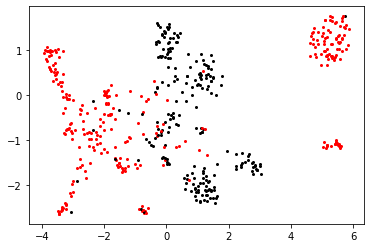

In [80]:
def DataViz(figname, algorithm, cluster1, cluster2, cluster3, results):
    coloring = []
    truthnum1 = DataCollectionTumorTvP(algorithm, cluster1, cluster2, cluster3, results)
    for i in truthnum1:
        coloring.append(truthnum1[i])
    for i in range(len(truthnum1)):
        plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
    labels = algorithm.labels_
    plt.savefig(figname)


DataViz("Birch Tumor Truth v. Predicted.png", birch, "birch_tumor1.txt", "birch_tumor2.txt", "birch_tumor3.txt", "birch_results.txt")
# truthnum1, truthnum2 = DataCollectionTumor(ms, "birch_tumor1.txt", "birch_tumor2.txt", "birch_tumor3.txt", "birch_results.txt")
# plt.figure(figsize=(50, 50))
# plt.xticks(())
# plt.yticks(())
# for g in range(len(truthnum1)):
#     plt.scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=4, color="white")
#     mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
#     plt.annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=35) 
# plt.savefig("Birch Tumorous and Molecular Cell Type.png")   
# plt.show()